# **05. Implementación del modelo elegido**

### Librerias

In [42]:
from numpy import interp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from termcolor import colored, cprint
from sklearn.preprocessing import StandardScaler
import importlib
import warnings
import sys

import pickle
from joblib import dump, load

from sklearn.inspection import PartialDependenceDisplay
from sklearn import metrics
from sklearn.pipeline import Pipeline
import lightgbm
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
import scikitplot as skplt


from sklearn.metrics import balanced_accuracy_score, fbeta_score, make_scorer,\
                            accuracy_score,average_precision_score, precision_recall_curve, roc_curve,\
                            auc, recall_score, precision_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

### Funciones

In [43]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.width', 10000)

In [44]:
sys.path.append('../src/')
import functions as f
sys.path.remove('../src/')

In [45]:
# Constants
seed= 12345

### Carga de datos

In [46]:
df_loan_train = pd.read_csv("../data/df_train_resampled.csv")
df_loan_test = pd.read_csv("../data/data_test_processed.csv")

#### Separación en train y test

In [47]:
X_train = df_loan_train.drop('TARGET', axis=1)
y_train = df_loan_train['TARGET']

X_test = df_loan_test.drop('TARGET', axis=1)
y_test = df_loan_test['TARGET']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((196803, 27), (196803,), (61503, 27), (61503,))

## **Entrenamiento del modelo con los hiperparámetros**

En esta sección, vamos a entrenar el modelo LightGBM y el modelo XGBoost utilizando los mejores hiperparámetros obtenidos por búsqueda aleatoria. Estos hiperparámetros fueron ajustados para maximizar el rendimiento del modelo, teniendo en cuenta factores como el subsample, num_leaves, learning_rate, max_depth, entre otros. La optimización de estos parámetros es crucial para evitar problemas de sobreajuste y mejorar el rendimiento general del modelo.

### **Modelo LightGBM**

In [48]:
cv = load('../models/CV_lgbm.joblib')
cv.best_params_

{'subsample': 0.9749394912418917,
 'num_leaves': 209,
 'n_estimators ': 188,
 'min_data_in_leaf': 1454,
 'min_child_samples': 528,
 'max_depth': 8,
 'learning_rate': 0.04053035597617399,
 'colsample_bytree': 0.945656458361092}

In [49]:
lgbm = LGBMClassifier(subsample=0.9749394912418917
                      ,num_leaves=209
                      ,n_estimators=188
                      ,min_data_in_leaf=1454
                      ,min_child_samples=528
                      ,max_depth=4 # reducimos a la mitad este valor para evitar overfitting y mejorar el rendimiento
                      ,learning_rate=0.04053035597617399
                      ,colsample_bytree=0.945656458361092
                      ,verbosity=-1)

lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

f.all_metrics(y_test, y_pred)

Accuracy: 0.91947
Balanced Accuracy: 0.50259
F2 Score: 0.00678
F1 Score: 0.01078
Precision: 0.64286
Recall: 0.00544

Confusion Matrix:
[[56523    15]
 [ 4938    27]]


In [50]:
y_pred_proba = lgbm.predict_proba(X_test)
y_pred_proba

array([[0.93794359, 0.06205641],
       [0.9012005 , 0.0987995 ],
       [0.96814744, 0.03185256],
       ...,
       [0.95987355, 0.04012645],
       [0.95832961, 0.04167039],
       [0.92743863, 0.07256137]])

#### Matrices de confusión

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred)

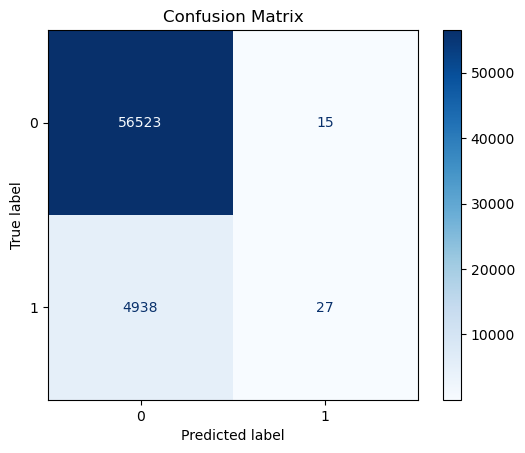

In [52]:
#Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

#Plot the confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [53]:
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

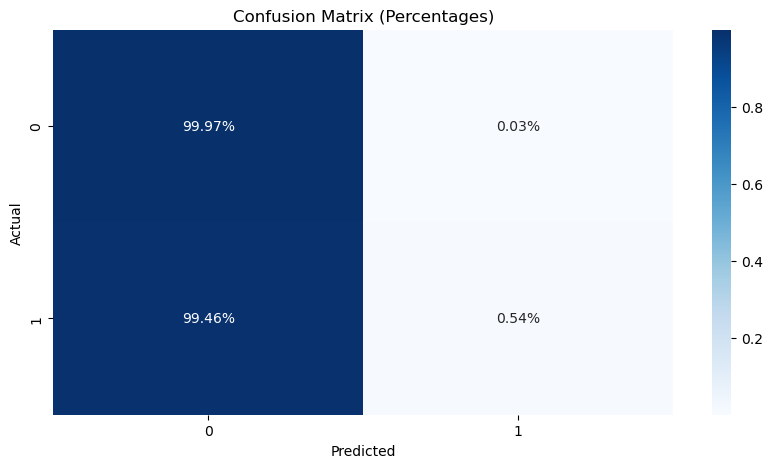

In [54]:
# Plot confusion matrix in percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues') 
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **ROC Curve**

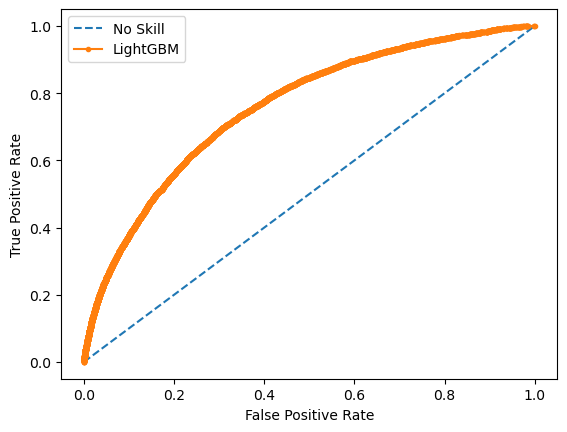

In [55]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Observamos que el modelo LightGBM presenta una curva ROC significativamente superior a la del modelo sin habilidad. La curva del modelo LightGBM se aleja considerablemente de la diagonal, lo que indica que tiene una buena capacidad de clasificación, especialmente al separar las clases positivas y negativas. La tasa de verdaderos positivos aumenta rápidamente mientras que la tasa de falsos positivos se mantiene baja.

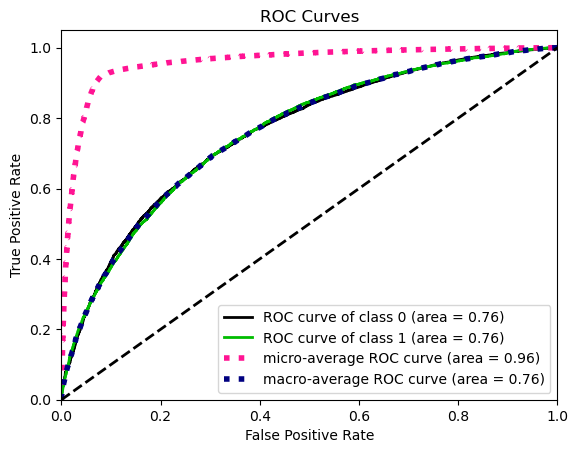

In [57]:
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()

Las curvas ROC para cada clase (0 y 1), junto con las curvas de promedios micro y macro, que nos proporcionan una visión más completa del rendimiento del modelo. El área bajo la curva (AUC) para ambas clases es bastante alta, lo que indica que el modelo tiene un buen rendimiento general y es capaz de identificar correctamente las instancias de ambas clases.

En general, las curvas ROC y los valores de AUC muestran que LightGBM es un modelo eficaz para este problema de clasificación, aunque siempre es importante seguir evaluando el rendimiento en función de otros indicadores como precisión, recall y F1 Score.

### **Cumulative Gain Curve**

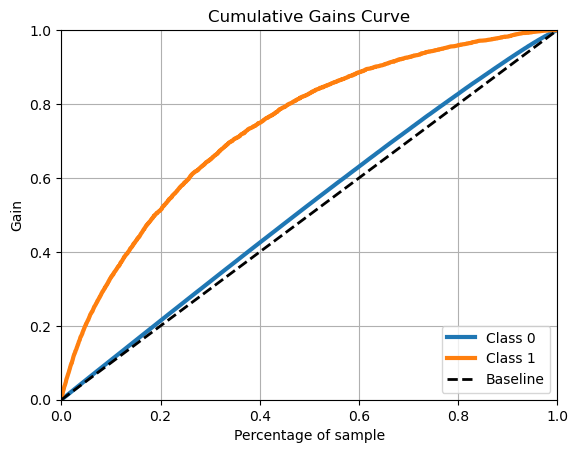

In [58]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba)
plt.show()

Este gráfico muestra el desempeño acumulado del modelo al clasificar las instancias. Se observa que la curva correspondiente a la clase 1 (color naranja) tiene un aumento significativo en comparación con la clase 0 (color azul), lo que indica que el modelo está logrando captar una mayor proporción de instancias positivas al principio, es decir, es más eficiente para identificar los casos positivos.
La línea discontinua (baseline) representa la estrategia de predicción aleatoria. El modelo supera significativamente esta línea, lo que confirma que tiene un rendimiento superior al de un modelo sin habilidad.

### **Lift Curve**

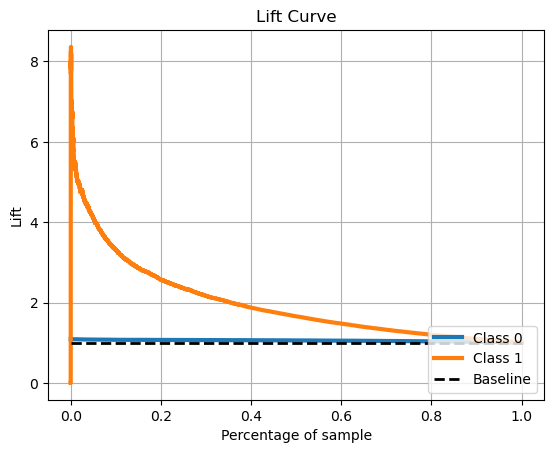

In [59]:
skplt.metrics.plot_lift_curve(y_test, y_pred_proba)
plt.show()

Este gráfico muestra el "lift" del modelo, que refleja cuántos mejores resultados de clasificación se obtienen en comparación con un modelo aleatorio. Al igual que en el gráfico anterior, la curva de la clase 1 (naranja) tiene un inicio abrupto en el que el modelo clasifica correctamente una alta proporción de instancias positivas. Sin embargo, a medida que se avanza en el porcentaje de muestra, la mejora en el lift se reduce, lo que es típico en este tipo de problemas desbalanceados.
La línea azul (para la clase 0) es casi horizontal, lo que indica que la predicción para esta clase no es tan efectiva, y la línea discontinua muestra el rendimiento esperado en un escenario aleatorio.

### Partial Dependence Plots

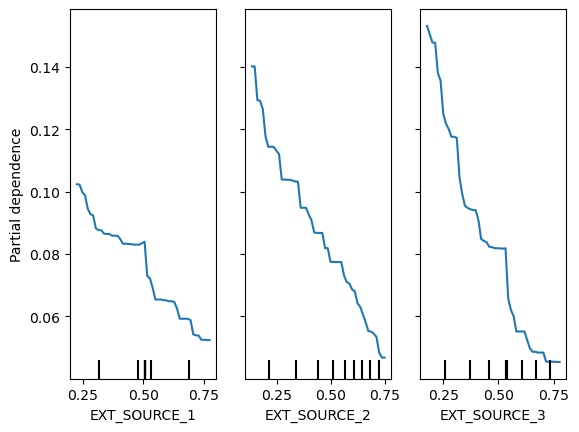

In [60]:
features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
PartialDependenceDisplay.from_estimator(lgbm, X_test, features, grid_resolution=50)
plt.show()

### **Modelo XGBoost**

Entrenado el modelo XGBoost utilizando los hiperparámetros seleccionados a través de una búsqueda aleatoria (RandomizedSearchCV). Estos parámetros, como el número de estimadores (n_estimators), la tasa de aprendizaje (learning_rate) y la profundidad máxima de los árboles (max_depth), fueron cuidadosamente ajustados para evitar el sobreajuste y mejorar el rendimiento general del modelo. El modelo fue ajustado y entrenado sobre el conjunto de datos de entrenamiento, y luego se realizaron predicciones sobre el conjunto de prueba.

In [61]:
cv2 = load('../models/CV_xgboost.joblib')
cv2.best_params_

{'subsample': 0.8450517312116986,
 'n_estimators': 865,
 'min_child_weight': 4,
 'max_leaves': 5,
 'max_depth': 9,
 'learning_rate': 0.04122879257345018,
 'gamma': 0.22098017584158963,
 'colsample_bytree': 0.9230232975495047}

In [62]:
xgb = XGBClassifier(n_estimators=865,
                    gamma=0.22098017584158963,
                    max_depth=5,  # de nuevo tomamos un valor más pequeño para evitar overfitting y mejorar el rendimiento
                    learning_rate=0.04122879257345018,
                    subsample=0.8450517312116986,
                    min_child_weight=4,
                    colsample_bytree=0.9230232975495047,
                    max_leaves=5,
                    verbosity=1)

xgb.fit(X_train, y_train)

y_pred2 = xgb.predict(X_test)

f.all_metrics(y_test, y_pred2)

Accuracy: 0.91963
Balanced Accuracy: 0.50809
F2 Score: 0.02149
F1 Score: 0.03363
Precision: 0.57333
Recall: 0.01732

Confusion Matrix:
[[56474    64]
 [ 4879    86]]


In [63]:
y_pred_proba2 = xgb.predict_proba(X_test)
y_pred_proba2

array([[0.9286787 , 0.07132129],
       [0.90862453, 0.09137549],
       [0.9758133 , 0.02418665],
       ...,
       [0.9601554 , 0.03984456],
       [0.9637232 , 0.03627679],
       [0.9393477 , 0.06065234]], dtype=float32)

### Matrices de confusión

In [64]:
conf_matrix2 = confusion_matrix(y_test, y_pred2)

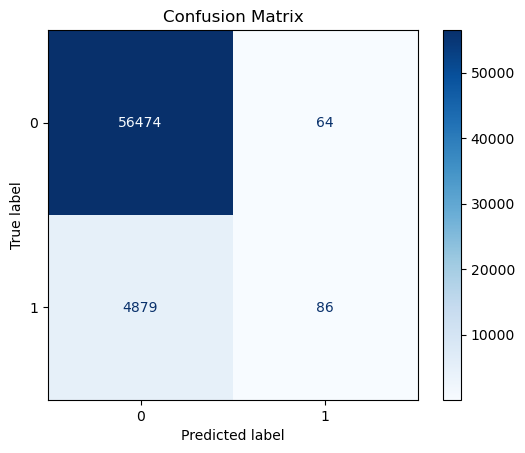

In [65]:
#Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2)

#Plot the confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [66]:
conf_matrix_percent2 = conf_matrix2 / conf_matrix2.sum(axis=1)[:, np.newaxis]

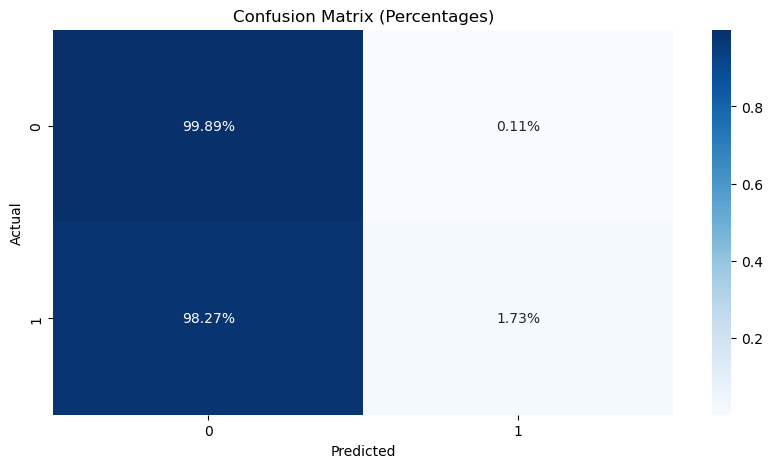

In [67]:
# Plot confusion matrix in percentages
conf_matrix_percent2 = conf_matrix2 / conf_matrix2.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix_percent2, annot=True, fmt='.2%', cmap='Blues') 
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **ROC Curve**

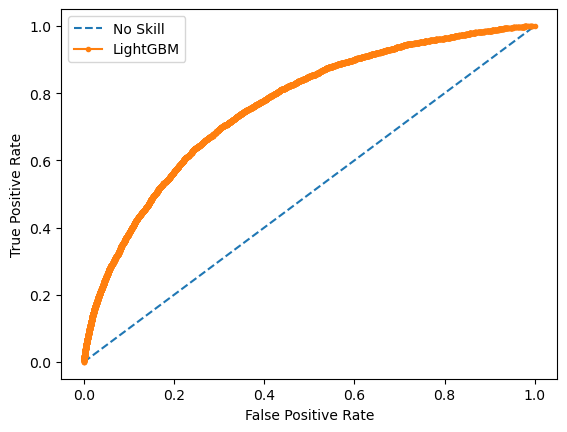

In [68]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba2[:, 1])
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
skplt.metrics.plot_roc(y_test, y_pred_proba)2
plt.show()

### **Cumulative Gain Curve**

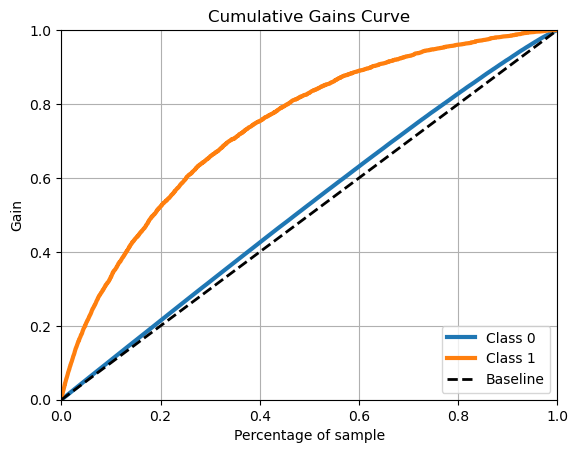

In [70]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba2)
plt.show()

### **Lift Curve**

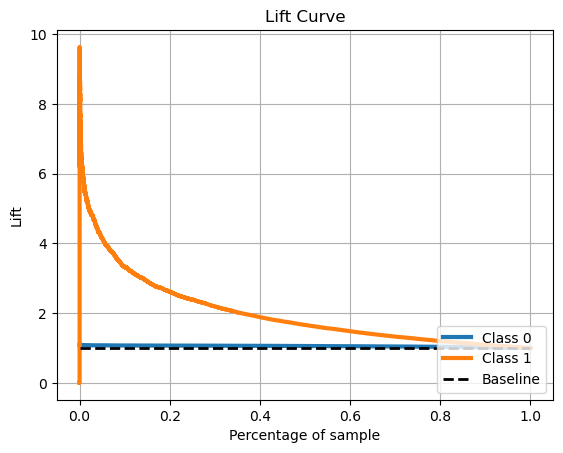

In [71]:
skplt.metrics.plot_lift_curve(y_test, y_pred_proba2)
plt.show()

### Partial Dependence Plots

In [ ]:
features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
PartialDependenceDisplay.from_estimator(xgb, X_test, features, grid_resolution=50)
plt.show()

En base a los análisis realizados, hemos observado que el modelo actual tiene un buen desempeño, pero aún se pueden mejorar ciertos aspectos, especialmente en la clasificación de la clase positiva (en particular, la reducción de falsos negativos). Para mejorar la precisión y obtener un modelo más robusto, hemos decidido optar por LightGBM.

LightGBM es un algoritmo de Gradient Boosting eficiente, conocido por su capacidad para manejar grandes volúmenes de datos, su velocidad de entrenamiento y su capacidad para manejar tanto variables categóricas como continuas. Además, LightGBM es ideal para tareas de clasificación binaria y puede mejorar el desempeño en el manejo de desequilibrio entre clases, lo cual es relevante en nuestro caso.

### Guargar el modelo

In [72]:
dump(lgbm, '../models/lgbm_model.joblib')

['../models/lgbm_model.joblib']

In [73]:
dump(xgb, '../models/xgb_model.joblib')

['../models/xgb_model.joblib']